# Dataset ARE

In [33]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten

In [34]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('ARE-Historical-Data-2015.csv')
df1=df.reset_index()['Price']

In [35]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [36]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [37]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [38]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [39]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [40]:
# Xây dựng mô hình TDNN
window_size = 100
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=window_size, activation='relu', input_shape=(window_size, 1)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

In [41]:
# 9. Fit mô hình với dữ liệu train
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
22/22 [==============================] - 1s 10ms/step - loss: 0.0364 - val_loss: 0.0030
Epoch 2/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0068 - val_loss: 0.0037
Epoch 3/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0053 - val_loss: 0.0033
Epoch 4/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0046 - val_loss: 0.0025
Epoch 5/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0041 - val_loss: 0.0026
Epoch 6/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0036 - val_loss: 0.0019
Epoch 7/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0032 - val_loss: 0.0015
Epoch 8/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0028 - val_loss: 0.0014
Epoch 9/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0026 - val_loss: 0.0012
Epoch 10/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 11

In [42]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

4/4 [==============================] - 0s 4ms/step


In [43]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [44]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 95.22352936567198
Testing RMSE: 100.25279414336842


In [45]:
# Dự báo 30 ngày tiếp theo
x_input = val_data[-100:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output = []
n_steps = 100
i = 0

while i < 7:
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

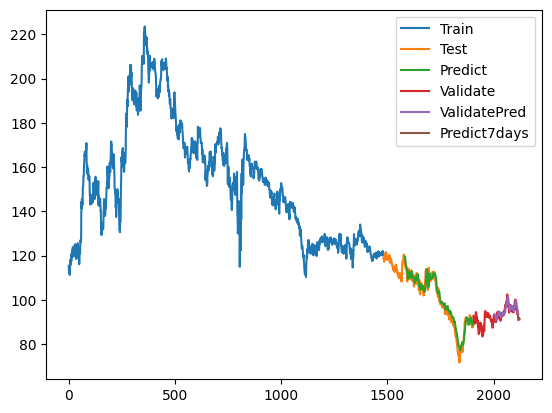

In [46]:
# 14.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+6, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict7days'])
plt.show()

In [47]:
scaler.inverse_transform(lst_output)

array([[91.81284406],
       [91.6207778 ],
       [91.66155082],
       [91.26009583],
       [91.2826318 ],
       [91.23420266],
       [91.34563745]])

# Dataset ARI

In [48]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('ARI-Historical-Data-2015.csv')
df1=df.reset_index()['Price']

In [49]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [50]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [51]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [52]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [53]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [54]:
# Xây dựng mô hình TDNN
window_size = 100
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=window_size, activation='relu', input_shape=(window_size, 1)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

In [55]:
# 9. Fit mô hình với dữ liệu train
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
22/22 [==============================] - 1s 12ms/step - loss: 0.0874 - val_loss: 0.0226
Epoch 2/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0152 - val_loss: 0.0020
Epoch 3/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0092 - val_loss: 0.0011
Epoch 4/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0065 - val_loss: 0.0011
Epoch 5/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0050 - val_loss: 8.5568e-04
Epoch 6/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0041 - val_loss: 7.9822e-04
Epoch 7/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0036 - val_loss: 7.2102e-04
Epoch 8/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0032 - val_loss: 6.7478e-04
Epoch 9/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0028 - val_loss: 6.2220e-04
Epoch 10/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0026 - val_l

In [56]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

4/4 [==============================] - 0s 5ms/step


In [57]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [58]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 16.3084872306051
Testing RMSE: 15.889779068885126


In [59]:
# Dự báo 7 ngày tiếp theo
x_input = val_data[-100:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output = []
n_steps = 100
i = 0

while i < 7:
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

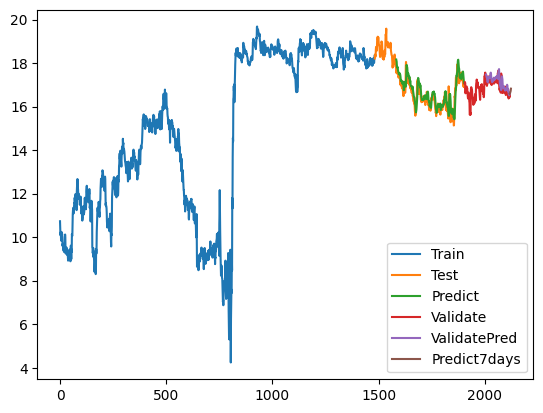

In [60]:
# 14.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+6, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict7days'])
plt.show()

In [61]:
scaler.inverse_transform(lst_output)

array([[16.58668916],
       [16.59638079],
       [16.61927867],
       [16.66053829],
       [16.68607925],
       [16.74283113],
       [16.8225453 ]])

# Dataset MAA

In [62]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('MAA-Historical-Data-2015.csv')
df1=df.reset_index()['Price']

In [63]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [64]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [65]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [66]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [67]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [68]:
# Xây dựng mô hình TDNN
window_size = 100
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=window_size, activation='relu', input_shape=(window_size, 1)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

In [69]:
# 9. Fit mô hình với dữ liệu train
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
22/22 [==============================] - 1s 11ms/step - loss: 0.0197 - val_loss: 0.0025
Epoch 2/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0051 - val_loss: 0.0011
Epoch 3/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0038 - val_loss: 8.7677e-04
Epoch 4/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0028 - val_loss: 6.9427e-04
Epoch 5/100
22/22 [==============================] - 0s 9ms/step - loss: 0.0022 - val_loss: 5.8045e-04
Epoch 6/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0018 - val_loss: 4.6530e-04
Epoch 7/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 4.2563e-04
Epoch 8/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 5.9990e-04
Epoch 9/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 3.7255e-04
Epoch 10/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0012

In [70]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

4/4 [==============================] - 0s 4ms/step


In [71]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [72]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 77.31900241967506
Testing RMSE: 96.64600391706634


In [73]:
# Dự báo 7 ngày tiếp theo
x_input = val_data[-100:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output = []
n_steps = 100
i = 0

while i < 7:
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

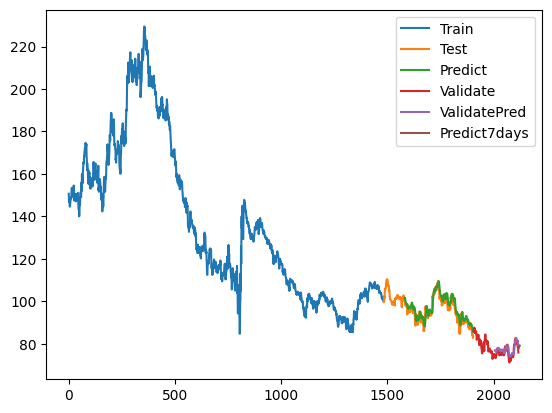

In [74]:
# 14.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+6, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict7days'])
plt.show()

In [75]:
scaler.inverse_transform(lst_output)

array([[77.62662659],
       [77.78650491],
       [77.99730767],
       [78.32813901],
       [78.56965623],
       [78.84342166],
       [79.10534168]])